In [1]:
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [12, 8]

In [2]:
EPSILON = 0.0001


def reflect(vector, normal_vector):
    """Returns reflected vector."""
    n_dot_l = np.dot(vector, normal_vector)
    return vector - normal_vector * (2 * n_dot_l)


def normalize(vector):
    """Return normalized vector (length 1)."""
    return vector / np.sqrt((vector**2).sum())

In [3]:
class Ray:
    """Ray class."""
    def __init__(self, starting_point, direction):
        """Ray consist of starting point and direction vector."""
        self.starting_point = starting_point
        self.direction = direction


class Light:
    """Light class."""
    def __init__(self, position):
        """The constructor.

        :param np.array position: The position of light
        :param np.array ambient: Ambient light RGB
        :param np.array diffuse: Diffuse light RGB
        :param np.array specular: Specular light RGB
        """
        self.position = position
        self.ambient=np.array([0, 0, 0])
        self.diffuse=np.array([0, 1, 1])
        self.specular=np.array([1, 1, 0])


class SceneObject:
    """The base class for every scene object."""
    def __init__(
        self,
        ambient=np.array([0, 0, 0]),
        diffuse=np.array([0.6, 0.7, 0.8]),
        specular=np.array([0.8, 0.8, 0.8]),
        shining=25
    ):
        """The constructor.

        :param np.array ambient: Ambient color RGB
        :param np.array diffuse: Diffuse color RGB
        :param np.array specular: Specular color RGB
        :param float shining: Shinging parameter (Phong model)
        """
        self.ambient = ambient
        self.diffuse = diffuse
        self.specular = specular
        self.shining = shining

    def get_normal(self, cross_point):
        """Should return a normal vector in a given cross point.

        :param np.array cross_point
        """
        raise NotImplementedError

    def trace(self, ray):
        """Checks whenever ray intersect with an object.

        :param Ray ray: Ray to check intersection with.
        :return: tuple(cross_point, distance)
            cross_point is a point on a surface hit by the ray.
            distance is the distance from the starting point of the ray.
            If there is no intersection return (None, None).
        """
        raise NotImplementedError

    def get_color(self, cross_point, obs_vector, scene):
        """Returns a color of an object in a given point.

        :param np.array cross_point: a point on a surface
        :param np.array obs_vector: observation vector used in Phong model
        :param Scene scene: A scene object (for lights)
        """

        color = self.ambient * scene.ambient
        light = scene.light

        normal = self.get_normal(cross_point)
        light_vector = normalize(light.position - cross_point)
        n_dot_l = np.dot(light_vector, normal)
        reflection_vector = normalize(reflect(-1 * light_vector, normal))

        v_dot_r = np.dot(reflection_vector, -obs_vector)

        if v_dot_r < 0:
            v_dot_r = 0

        if n_dot_l > 0:
            color += (
                (self.diffuse * light.diffuse * n_dot_l) +
                (self.specular * light.specular * v_dot_r**self.shining) +
                (self.ambient * light.ambient)
            )

        return color


class Sphere(SceneObject):
    """An implementation of a sphere object."""
    def __init__(
        self,
        position,
        radius,
        ambient=np.array([0, 0, 0]),
        diffuse=np.array([0.6, 0.7, 0.8]),
        specular=np.array([0.8, 0.8, 0.8]),
        shining=25
    ):
        """The constructor.

        :param np.array position: position of a center of a sphere
        :param float radius: a radius of a sphere
        """
        super(Sphere, self).__init__(
            ambient=ambient,
            diffuse=diffuse,
            specular=specular,
            shining=shining
        )
        self.position = position
        self.radius = radius

    def get_normal(self, cross_point):
        return normalize(cross_point - self.position)

    def trace(self, ray):
        """Returns cross point and distance or None."""
        distance = ray.starting_point - self.position

        a = np.dot(ray.direction, ray.direction)
        b = 2 * np.dot(ray.direction, distance)
        c = np.dot(distance, distance) - self.radius**2
        d = b**2 - 4*a*c

        if d < 0:
            return (None, None)

        sqrt_d = d**(0.5)
        denominator = 1 / (2 * a)

        if d > 0:
            r1 = (-b - sqrt_d) * denominator
            r2 = (-b + sqrt_d) * denominator
            if r1 < EPSILON:
                if r2 < EPSILON:
                    return (None, None)
                r1 = r2
        else:
            r1 = -b * denominator
            if r1 < EPSILON:
                return (None, None)

        cross_point = ray.starting_point + r1 * ray.direction
        return cross_point, r1

In [4]:
class Camera:
    """Implementation of a Camera object."""
    def __init__(
        self,
        position = np.array([0, 0, -3]),
        look_at = np.array([0, 0, 0]),
    ):
        """The constructor.

        :param np.array position: Position of the camera.
        :param np.array look_at: A point that the camera is looking at.
        """
        self.z_near = 1
        self.pixel_height = 500
        self.pixel_width = 700
        self.povy = 45
        look = normalize(look_at - position)
        self.up = normalize(np.cross(np.cross(look, np.array([0, 1, 0])), look))
        self.position = position
        self.look_at = look_at
        self.direction = normalize(look_at - position)
        aspect = self.pixel_width / self.pixel_height
        povy = self.povy * np.pi / 180
        self.world_height = 2 * np.tan(povy/2) * self.z_near
        self.world_width = aspect * self.world_height

        center = self.position + self.direction * self.z_near
        width_vector = normalize(np.cross(self.up, self.direction))
        self.translation_vector_x = width_vector * -(self.world_width / self.pixel_width)
        self.translation_vector_y = self.up * -(self.world_height / self.pixel_height)
        self.starting_point = center + width_vector * (self.world_width / 2) + (self.up * self.world_height / 2)

    def get_world_pixel(self, x, y):
        return self.starting_point + self.translation_vector_x * x + self.translation_vector_y * y


class Scene:
    """Container class for objects, light and camera."""
    def __init__(
        self,
        objects,
        light,
        camera
    ):
        self.objects = objects
        self.light = light
        self.camera = camera
        self.ambient = np.array([0.1, 0.1, 0.1])
        self.background = np.array([0, 0, 0])


class RayTracer:
    """RayTracer class."""
    def __init__(self, scene):
        """The constructor.

        :param Scene scene: scene to render
        """
        self.scene = scene

    def generate_image(self):
        """Generates image.

        :return np.array image: The computed image."
        """
        camera = self.scene.camera
        image = np.zeros((camera.pixel_height, camera.pixel_width, 3))
        for y in range(image.shape[0]):
            for x in range(image.shape[1]):
                world_pixel = camera.get_world_pixel(x, y)
                direction = normalize(world_pixel - camera.position)
                image[y][x] = self._get_pixel_color(Ray(world_pixel, direction))
        return image

    def _get_pixel_color(self, ray):
        """Gets a single color based on a ray.

        :return np.array: A hit object color or a background.
        """

        obj, distance, cross_point = self._get_closest_object(ray)

        if not obj:
            return self.scene.background

        return obj.get_color(cross_point, ray.direction, self.scene)

    def _get_closest_object(self, ray):
        """Finds the closes object to the ray.

        :return tuple(scene_object, distance, cross_point)
            scene_object SceneObject: hit object or None (if no hit)
            distance float: Distance to the the scene_object
            cross_point np.array: the interection point.
        """
        closest = None
        min_distance = np.inf
        min_cross_point = None
        for obj in self.scene.objects:
            cross_point, distance = obj.trace(ray)
            if cross_point is not None and distance < min_distance:
                min_distance = distance
                closest = obj
                min_cross_point = cross_point

        return (closest, min_distance, min_cross_point)

# Przykład

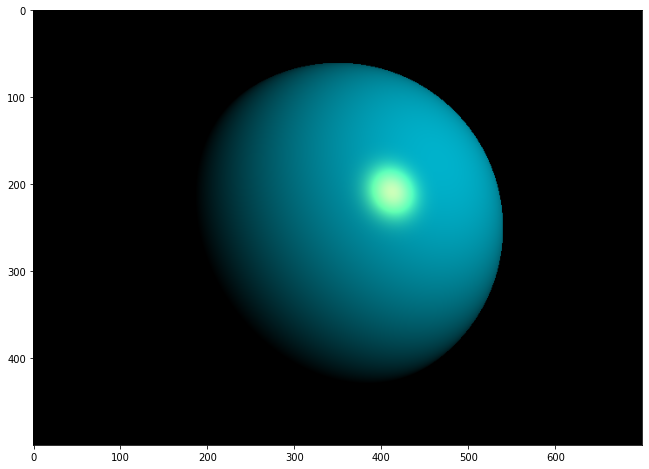

In [11]:
scene = Scene(
    objects=[Sphere(position=np.array([0, 0, 0]), radius=1.5)],
    light=Light(position=np.array([3, 2, 5])),
    camera=Camera(position=np.array([0, 0, 5]))
)

rt = RayTracer(scene)
image = np.clip(rt.generate_image(), 0, 1)
plt.imshow(image)

# Zadanie 1

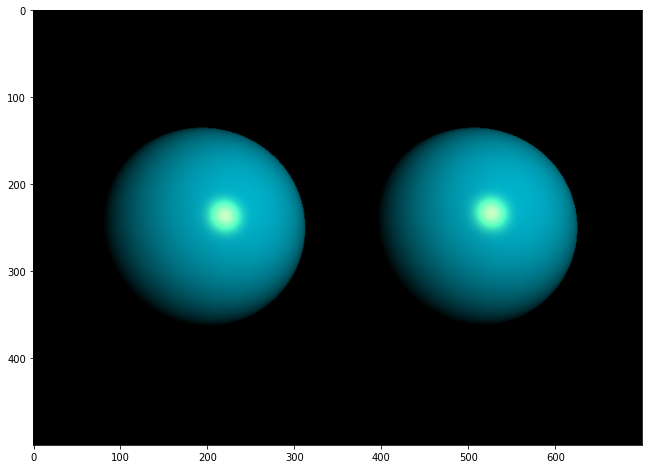

In [20]:
# TODO: Zmodyfikuj scenę – dodaj przynajmniej jedną sferę.
#       Można zmienić położenie, kolor, promień, itd.

scene = Scene(
    objects=[
        Sphere(position=np.array([-2, 0, -3]), radius=1.5),
        Sphere(position=np.array([2, 0, -3]), radius=1.5)
    ],
    light=Light(position=np.array([3, 2, 5])),
    camera=Camera(position=np.array([0, 0, 5]))
)

rt = RayTracer(scene)
image = np.clip(rt.generate_image(), 0, 1)
plt.imshow(image)

# Zadanie 2

In [ ]:
# TODO: Zmień funkcję _get_pixel_color() tak, aby działała rekurencyjnie.
#       Kolor wyjściowy powinien być ważoną sumą koloru obiektu i koloru uzyskanego przez odbicie
#       (wagi należy dobrać eksperymentalnie, samodzielnie, np. 0.7 i 0.3).
#       Należy również pamiętać o ograniczeniu liczby odbić (parametr depth).

class MyRayTracer(RayTracer):
    def _get_pixel_color(self, ray, depth=3):
        """Gets a single color based on a ray.

        :return np.array: A hit object color or a background.
        """

        obj, distance, cross_point = self._get_closest_object(ray)

        if not obj:
            return self.scene.background

        return obj.get_color(cross_point, ray.direction, self.scene)

# Zadanie 3

In [ ]:
# TODO: Zmodyfikuj funkcję get_color() tak, aby upewnić się, ze dany punkt nie znajduje się w cieniu.
#       Innymi słowy, pomiędzy punktem przecięcia, a źródłem światła, nie może znajdować się żaden obiekt.
#       Jak coś się tam znajduje – to w finalnym kolorze nie uwzględniamy koloru z modelu Phonga.

class MySphere(Sphere):
    def get_color(self, cross_point, obs_vector, scene):
        """Returns a color of an object in a given point.

        :param np.array cross_point: a point on a surface
        :param np.array obs_vector: observation vector used in Phong model
        :param Scene scene: A scene object (for lights)
        """
        color = self.ambient * scene.ambient
        light = scene.light

        normal = self.get_normal(cross_point)
        light_vector = normalize(light.position - cross_point)
        n_dot_l = np.dot(light_vector, normal)
        reflection_vector = normalize(reflect(-1 * light_vector, normal))

        v_dot_r = np.dot(reflection_vector, -obs_vector)

        if v_dot_r < 0:
            v_dot_r = 0

        if n_dot_l > 0:
            color += (
                (self.diffuse * light.diffuse * n_dot_l) +
                (self.specular * light.specular * v_dot_r**self.shining) +
                (self.ambient * light.ambient)
            )

        return color

# Zadanie 4

In [ ]:
# TODO: Zmień funkcję _get_pixel_color() tak, aby uwzględniała przezroczystość
#       (z punktu przecięcia wysyłamy wtedy dwa promienie: odbity i załamany).
#       Do wag finalnego koloru dodajemy kolejną, uwzględniającą przezroczystość obiektów
#       (np. kolor lokalny: 0.4, odbity: 0.3, załamany: 0.3).
#       Tę ostatnią wagę należy wyznaczyć, bazując na stopniu przeźroczystości obiektu.

class MyRayTracer2(RayTracer):
    def _get_pixel_color(self, ray, depth=3):
        """Gets a single color based on a ray.

        :return np.array: A hit object color or a background.
        """

        obj, distance, cross_point = self._get_closest_object(ray)

        if not obj:
            return self.scene.background

        return obj.get_color(cross_point, ray.direction, self.scene)

# Zadanie 5

In [ ]:
# TODO: Stwórz klasę dowolnego obiektu innego niż kula i wyświetl go.
#       Obiekt powinien dziedziczyć po klasie SceneObject.
#       Jeżeli zmodyfikowano wcześniej funkcję get_color() to w tej klasie również należy ją nadpisać.